In [1]:
from smoke_segmentation_functions import initiate_model, get_tif_dataset, check_dir, convert_tif_to_image,  get_tiles, reconstruct_image, create_mask, get_segmeneted_mutiband_tif, get_segmented_tif, convert_tif_to_mask
import tensorflow as tf
import numpy as np
from osgeo import gdal

In [2]:
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("sequoiaandrade/Smoke-Cloud-Segmentation-RACE-ODIN")


c:\Users\srandrad\Anaconda3\envs\odin\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
variables/variables.index: 100%|██████████| 17.3k/17.3k [00:00<00:00, 2.17MB/s]



README.md: 100%|██████████| 1.09k/1.09k [00:00<00:00, 548kB/s]
.gitattributes: 100%|██████████| 1.59k/1.59k [00:00<00:00, 178kB/s]
c:\Users\srandrad\Anaconda3\envs\odin\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\srandrad\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingfac

In [3]:
model_path = r"C:\Users\srandrad\race-root\race\race-earth\src\main\python\smoke-segmentation\models\final_BT_unet.h5"

In [4]:
image_path = r"C:\Users\srandrad\race-root\race-data\goesr-truecolor\czu\OR_ABI-L2-MCMIPC-M6_G17_s20202321716176_e20202321718555_c20202321719081.tif"
    

In [5]:
target_shape = (512, 512)

In [6]:
segmentation_model = model#initiate_model(model_path)

In [7]:
original_tif = gdal.Open(image_path)
output_raster = r"C:\Users\srandrad\race-root\race-data\goesr-truecolor\czu\warped.tif"
warp = gdal.Warp(output_raster, original_tif, dstSRS='EPSG:4326', outputBounds=(-137, 24, -111, 49))
warp = None

In [8]:
def get_segmented_tif(original_tif, mask, output_path):
    driver = gdal.GetDriverByName("GTiff")
    rows, cols = mask.shape
    output_tif= driver.Create(output_path, cols, rows, 1, gdal.GDT_Byte)
    output_tif.SetGeoTransform(original_tif.GetGeoTransform())##sets same geotransform as input
    output_tif.SetProjection(original_tif.GetProjection())##sets same projection as input
    output_tif.SetMetadata(original_tif.GetMetadata())##sets same metadata as input and adds key for interpreting segmetation mask
    output_tif.GetRasterBand(1).WriteArray(mask)
    output_tif.FlushCache() ##saves to disk
    return output_tif

In [9]:
tif_dataset = get_tif_dataset(image_path)
# get original tif info
original_tif_geo_transform = tif_dataset.GetGeoTransform()
original_tif_proj = tif_dataset.GetProjection()
original_tif_meta = tif_dataset.GetMetadata()
# convert to image
image = convert_tif_to_image(tif_dataset)
del tif_dataset #closes original tiff
# process tif into tiles
images, full_tiled_shape, padding_tuple, overlap = get_tiles(image, target_shape, overlap=48)
# format images
inputs = tf.convert_to_tensor(np.asarray(images))#tf.image.resize(images, target_shape)
inputs_tf = tf.data.Dataset.from_tensor_slices((inputs))
inputs_tf_batch = inputs_tf.batch(32)
# run segmentation
pred = segmentation_model.predict( inputs_tf_batch)
# reconstruction
pred_reshaped = reconstruct_image(pred, full_tiled_shape, padding_tuple, target_shape, overlap=overlap)
# mask and final output
pred_mask = create_mask(pred_reshaped)
pred_mask = pred_mask.reshape(pred_mask.shape[:2])
output_path =  image_path.replace(".tif", "_segmented.tif")
output = get_segmented_tif(original_tif, pred_mask.numpy(), output_path)
# clear memory
del output #closes new tiff

1/1 [==============================] - 5s 5s/step


In [10]:
original_tif = gdal.Open(output_path)
output_segmented = r"C:\Users\srandrad\race-root\race-data\goesr-truecolor\czu\segmented_warped.tif"
warp = gdal.Warp(output_segmented, original_tif, dstSRS='EPSG:4326', outputBounds=(-137, 24, -111, 49))
warp = None

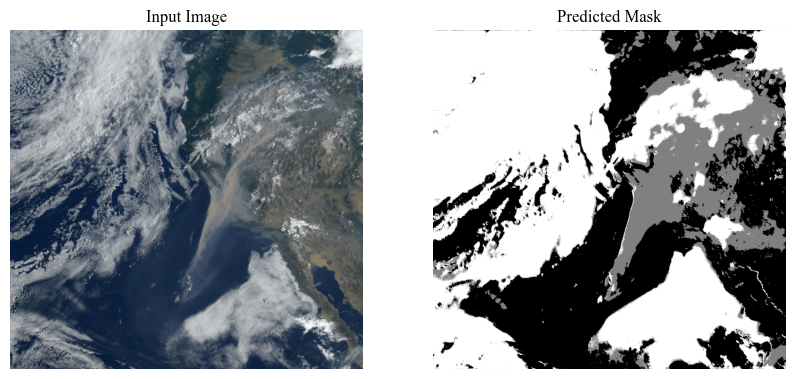

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(convert_tif_to_image(get_tif_dataset(output_raster)))
ax[0].set_title("Input Image")
ax[0].axis("off")

ax[1].imshow(convert_tif_to_mask(get_tif_dataset(output_segmented)), cmap="gray")
ax[1].set_title("Predicted Mask")
ax[1].axis("off")
plt.savefig("CZU_output.pdf")
plt.show()